In [1]:
import numpy as np
import pandas as pd
import toad
from toad.plot import bin_plot


In [2]:
data = pd.read_csv('test_data.csv')
print('Shape:',data.shape)
data.head(10)

Shape: (500, 7)


,A,B,C,D,E,F,target
0,0.417022,87,0.154276,0.383389,NaN,84.100880,0
1,0.720324,57,0.758797,0.769808,NaN,74.668182,1
2,0.000114,24,0.197145,-0.105166,NaN,7.504475,0
3,0.302333,55,0.442048,0.300465,NaN,46.824730,1
4,0.146756,49,0.399363,0.096637,NaN,45.993059,1
5,0.092339,52,0.045981,-0.022774,NaN,50.068966,1
6,0.186260,24,0.322268,-0.039216,NaN,37.597628,0
7,0.345561,15,0.311033,0.412043,NaN,26.698194,1
8,0.396767,67,0.393938,0.435124,NaN,56.782580,0
9,0.538817,73,0.407933,0.509187,NaN,71.328520,0


In [3]:
train = data.iloc[0:400]
OOT = data.iloc[400:500]
print('Train Shape:',train.shape)
print('OOT Shape:',OOT.shape)

Train Shape: (400, 7)
OOT Shape: (100, 7)


In [4]:
toad.detect(train)

,type,size,missing,unique,mean_or_top1,std_or_top2,min_or_top3,1%_or_top4,10%_or_top5,50%_or_bottom5,75%_or_bottom4,90%_or_bottom3,99%_or_bottom2,max_or_bottom1
A,float64,400,4.00%,384,0.510225,0.295621,0.000114,0.013714,0.094141,0.539891,0.759157,0.908319,0.989012,0.997323
B,int64,400,0.00%,99,50.977500,28.473036,0.000000,0.000000,13.900000,52.000000,77.000000,89.100000,98.010000,99.000000
C,float64,400,4.00%,384,0.519693,0.346923,-0.334533,-0.183144,0.086984,0.514571,0.780369,0.987038,1.239673,1.324568
D,float64,400,4.00%,384,0.508233,0.307564,-0.136864,-0.085891,0.075536,0.533025,0.772812,0.894724,1.098249,1.176546
E,float64,400,96.75%,13,0.479722,0.328087,0.100977,0.108849,0.172996,0.322044,0.817003,0.925371,0.952397,0.952534
F,float64,400,0.00%,400,51.034749,30.841419,-19.534221,-13.810217,10.052414,52.025739,76.880783,91.752029,107.372200,117.693548
target,int64,400,0.00%,2,0.502500,0.500620,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


输出每个变量的iv值，gini，entropy，和unique values，结果以iv值排序。”target”为目标列，”iv_only”决定是否只输出iv值

要去掉主键，日期等高unique values且不用于建模的特征

In [5]:
toad.quality(train, target='target', iv_only=False)

,iv,gini,entropy,unique
F,0.491614,0.494035,0.693135,400.0
D,0.420634,0.496323,0.693134,385.0
A,0.364871,0.494007,0.693135,385.0
C,0.352290,0.494480,0.693134,385.0
B,0.310251,0.496334,0.693135,99.0
E,0.026629,0.496044,0.691793,14.0


根据缺失值占比，iv值，和高相关性进行变量筛选，赋值为：

（1）empty=0.9: 若变量的缺失值大于0.9被删除

（2）iv=0.02: 若变量的iv值小于0.02被删除

（3）corr=0.7: 若两个相关性高于0.7时，iv值低的变量被删除

（4）return_drop=False: 若为True，function将返回被删去的变量列

（5）exclude=None: 明确不被删去的列名
下面结果表明空值条件删除了E列，iv值没有删除任何列，相关性删除了A，B，C列，剩余D，F列，输入为list格式

In [6]:
train_selected, dropped = toad.selection.select(train,target = 'target', empty = 0.5, iv = 0.05, corr = 0.7, return_drop=True, exclude=None)
print(dropped)
print(train_selected.shape)

{'empty': array(['E'], dtype='<U1'), 'iv': array([], dtype=object), 'corr': array(['C', 'B', 'A'], dtype=object)}
(400, 3)


分箱功能支持数值型数据和离散型分箱，默认分箱方法使用 卡方分箱。
*** initalise: ***c = toad.transform.Combiner()
*训练分箱*: c.fit(dataframe, y = ‘target’, method = ‘chi’, min_samples = None, n_bins = None, empty_separate = False)
y: 目标列
method: 分箱方法，支持’chi’ (卡方分箱), ‘dt’ (决策树分箱), ‘kmean’ , ‘quantile’ (等频分箱), ‘step’ (等步长分箱)
min_samples: 每箱至少包含样本量，可以是数字或者占比
n_bins: 箱数，若无法分出这么多箱数，则会分出最多的箱数
empty_separate: 是否将空箱单独分开
*查看分箱节点*：c.export()
*手动调整分箱*: c.load(dict)
*apply分箱结果*: c.transform(dataframe, labels=False):
labels: 是否将分箱结果转化成箱标签。False时输出0,1,2…（离散变量根据占比高低排序），True输出(-inf, 0], (0,10], 
    同样要删除不用于建模的量
    下面结果是两个连续数据给出的分箱节点(10, inf)。

In [7]:
# initialise
c = toad.transform.Combiner()

# 使用特征筛选后的数据进行训练：使用稳定的卡方分箱，规定每箱至少有5%数据, 空值将自动被归到最佳箱。
c.fit(train_selected, y = 'target', method = 'chi', min_samples = 0.05) #empty_separate = False

# 为了演示，仅展示部分分箱
print('D:',c.export()['D'])
print('F:',c.export()['F'])


D: [0.2152696212524343, 0.7149982120917635]
F: [14.605645472881228, 48.47334638888314, 54.189909599726825, 79.67128729823014, 88.62058274679619]


*时间内观察*： toad.plot.bin_plot(dataframe, x = None, target = ‘target)
bar代表了样本量占比，红线代表了正样本占比（e.g. 坏账率）

D:\daily_work\examination\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\daily_work\examination\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\daily_work\examination\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\daily_work\examination\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


<Axes: xlabel='F', ylabel='prop'>

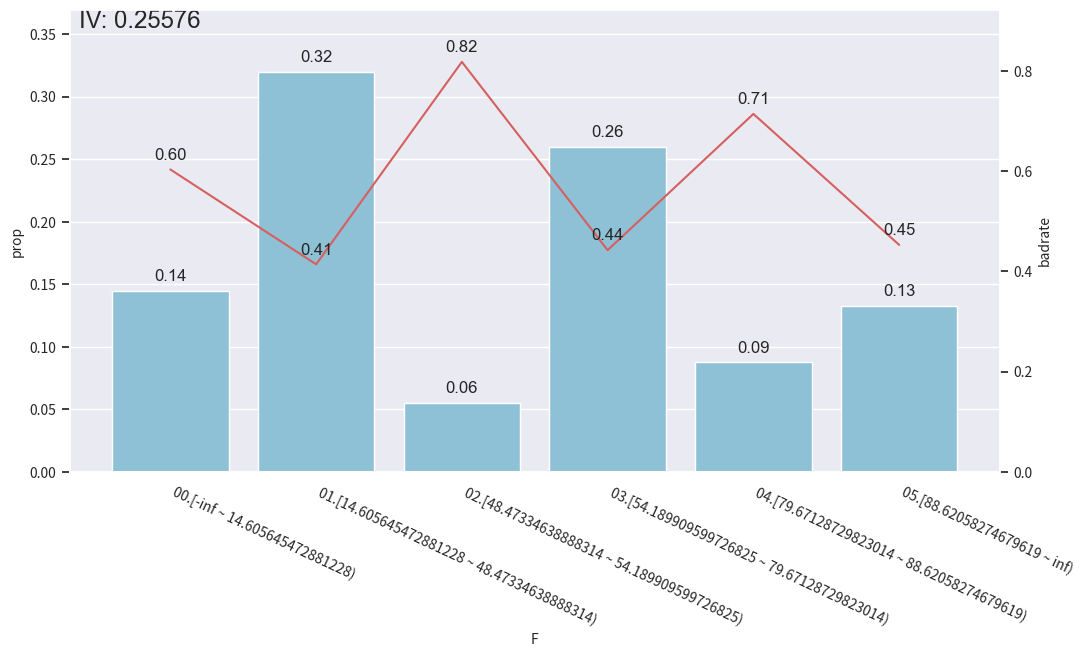

In [8]:
col = 'F'
bin_plot(c.transform(train_selected[[col,'target']], labels=True), x=col, target='target')

*跨时间观察：* toad.plot.badrate_plot(dataframe, target = ‘target’, x = None, by = None)
输出不同时间段中每箱的正样本占比

In [9]:
c.transform(train[[col,'target']]).index

RangeIndex(start=0, stop=400, step=1)

D:\daily_work\examination\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\daily_work\examination\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\daily_work\examination\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\daily_work\examination\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


'\n敞口随时间变化而增大为优，代表了变量在更新的E的区分度更强。线之前没有交叉为优，代表分箱稳定。\n'

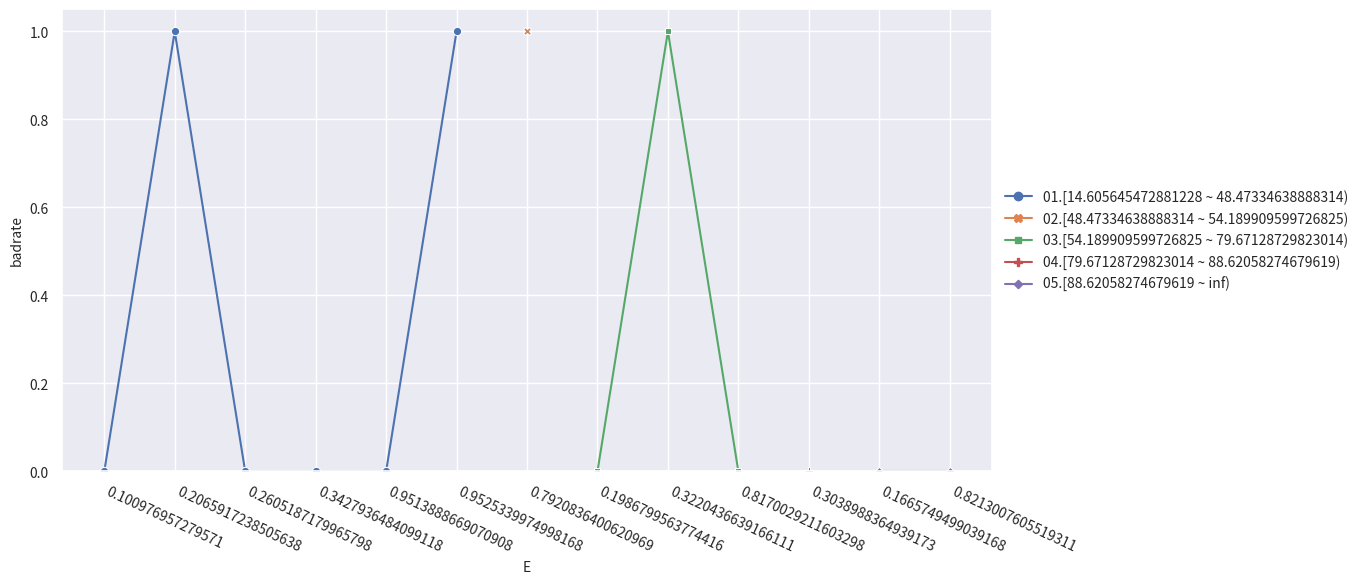

In [10]:
from toad.plot import badrate_plot
col = 'F'

# 观察 'F' 在E下的稳定性
# 这里因为没有时间数据选择了一个重复率较大，缺失值较少的E作为x轴来展示F随E变化的稳定性
badrate_plot(c.transform(train[[col,'target','E']], labels=True), target='target',x = 'E', by=col)
# badrate_plot(c.transform(OOT[[col,'target']], labels=True), target='target',x = None, by=col)

# badrate_plot(c.transform(data[[col,'target']], labels=True), target='target',x = None, by=col)
'''
敞口随时间变化而增大为优，代表了变量在更新的E的区分度更强。线之前没有交叉为优，代表分箱稳定。
'''

D:\daily_work\examination\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\daily_work\examination\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\daily_work\examination\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\daily_work\examination\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


<Axes: xlabel='D', ylabel='prop'>

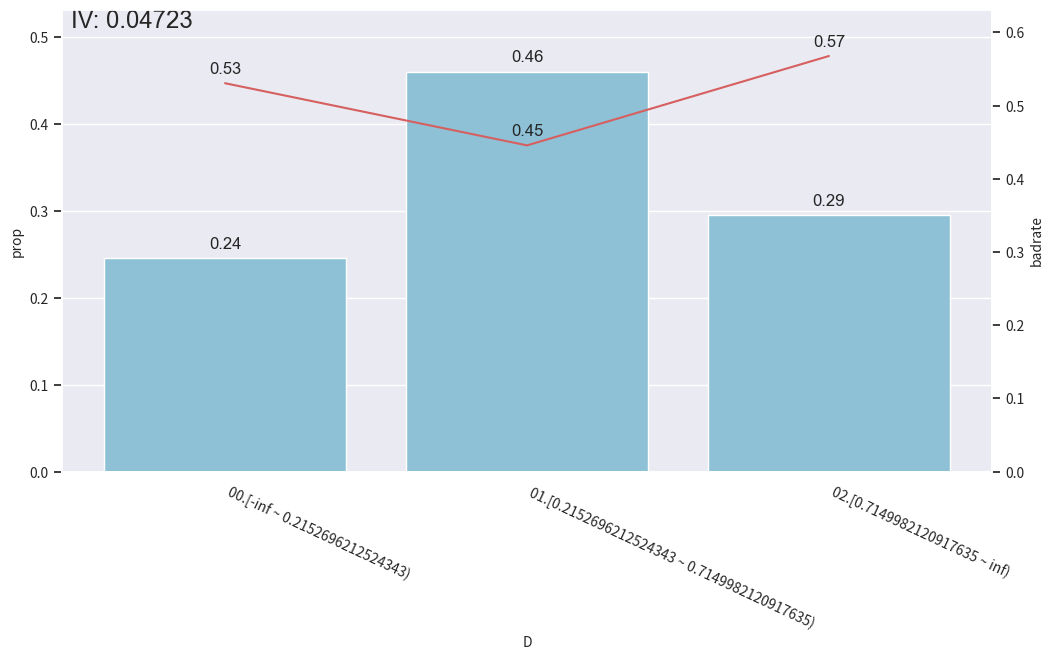

In [11]:
# 看'D'的分箱
col = 'D'

#观察单个变量分箱结果时，建议设置'labels = True'
bin_plot(c.transform(train_selected[[col,'target']], labels=True), x=col, target='target')

羡慕展示如何调整分箱

D:\daily_work\examination\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\daily_work\examination\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\daily_work\examination\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\daily_work\examination\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


<Axes: xlabel='E', ylabel='badrate'>

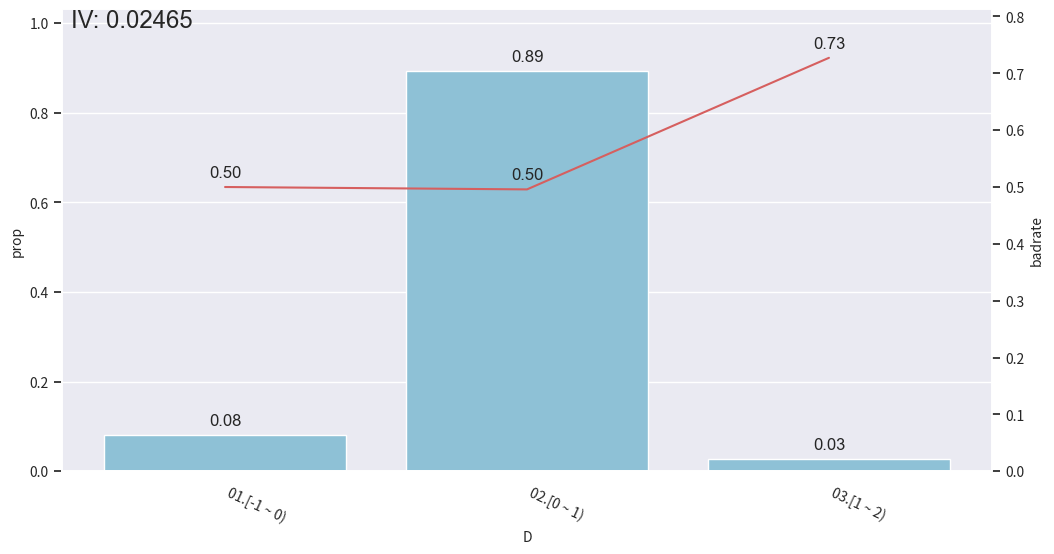

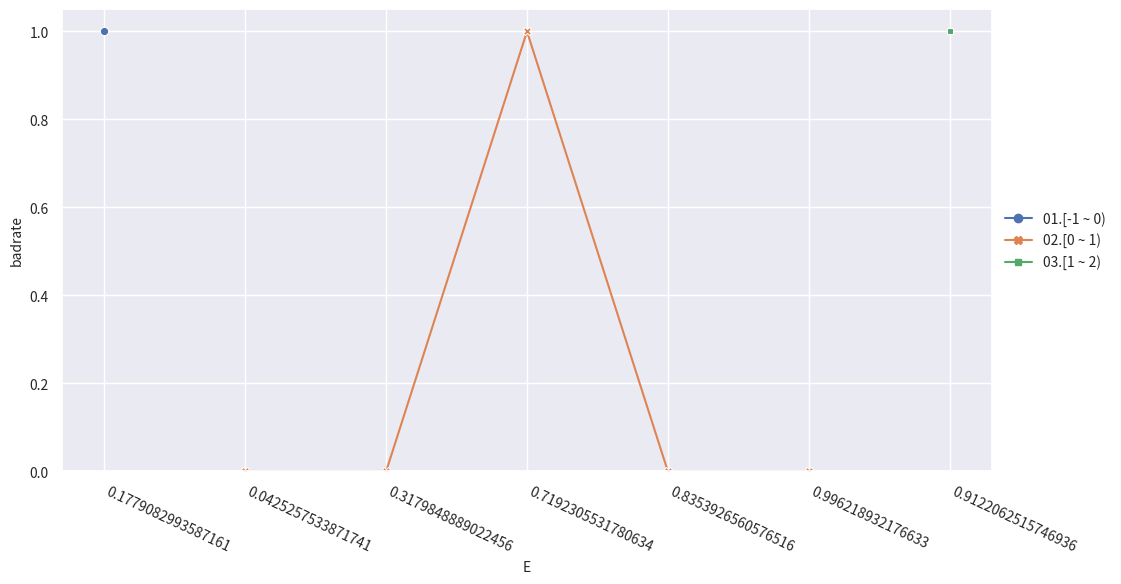

In [12]:
rule = {'D':[-1,0,1,2]}

#调整分箱
c.update(rule)

#查看手动分箱稳定性
bin_plot(c.transform(train_selected[['D','target']], labels=True), x='D', target='target')
badrate_plot(c.transform(OOT[['D','target','E']], labels=True), target='target', x='E', by='D')

WOE转化在分箱调整好之后进行，步骤如下：

*用调整好的Combiner转化数据:* c.transform(dataframe, labels=False)

只会转化被分箱的变量

*初始化woe transer:* transer = toad.transform.WOETransformer()

*fit_transform:* transer.fit_transform(dataframe, target, exclude = None)

训练并输出woe转化的数据，用于转化train/时间内数据

target：目标列数据（非列名）
exclude: 不需要被WOE转化的列 注意：会转化所有列，包括未被分箱transform的列，通过 ‘exclude’ 删去不要WOE转化的列，特别是target列
*根据训练好的transer，转化test/OOT数据：*transer.transform(dataframe)

In [13]:
# 初始化
transer = toad.transform.WOETransformer()

# combiner.transform() & transer.fit_transform() 转化训练数据，并去掉target列
train_woe = transer.fit_transform(c.transform(train_selected), train_selected['target'], exclude=['target'])
OOT_woe = transer.transform(c.transform(OOT))

print(train_woe.head(3))

          D         F  target
0 -0.026807  0.906291       0
1 -0.026807 -0.241802       1
2 -0.010000  0.409854       0


逐步回归特征筛选，支持向前，向后和双向。
- estimator: 用于拟合的模型，支持'ols', 'lr', 'lasso', 'ridge'

- direction: 逐步回归的方向，支持'forward', 'backward', 'both' （推荐）

- criterion: 评判标准，支持'aic', 'bic', 'ks', 'auc'

- max_iter: 最大循环次数

- return_drop: 是否返回被剔除的列名

- exclude: 不需要被训练的列名，比如ID列和时间列

In [14]:
# 将woe转化后的数据做逐步回归
final_data = toad.selection.stepwise(train_woe,target = 'target', estimator='ols', direction = 'both', criterion = 'aic', exclude = None)

# 将选出的变量应用于test/OOT数据
final_OOT = OOT_woe[final_data.columns]

print(final_data.shape) # 逐步回归从7个变量中选出了1个
col = list(final_data.drop(['target'],axis=1).columns)
print(col)

(400, 2)
['F']


输出每列特征的PSI，可以用于检验WOE转化后的特征稳定性

In [15]:
toad.metrics.PSI(final_data[col], final_OOT[col])


F    0.041555
dtype: float64

常用模型评分: toad. metrics. KS, F1, AUC

In [16]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(final_data[col], final_data['target'])

# 预测训练和隔月的OOT
pred_train = lr.predict_proba(final_data[col])[:,1]
pred_OOT = lr.predict_proba(final_OOT[col])[:,1]

In [17]:
from toad.metrics import KS, AUC

print('train KS',KS(pred_train, final_data['target']))
print('train AUC',AUC(pred_train, final_data['target']))

print('OTT KS',KS(pred_OOT, final_OOT['target']))
print('OTT AUC',AUC(pred_OOT, final_OOT['target']))

train KS 0.2021300532513313
train AUC 0.6170154253856346
OTT KS 0.12645523885989562
OTT AUC 0.4636692091529506


*PSI 同样可以用于验证分数的稳定性*

In [18]:
print(toad.metrics.PSI(pred_train,pred_OOT))


0.041554960747658715


KS bucket输出模型预测分箱后评判信息，包括每组的分数区间，样本量，坏账率，KS等
- bucket：分箱的数量

   - method：分箱方法，建议用'quantile'（等人数），或'step' (等分数步长)

bad\_rate为每组坏账率：（1）组之间的坏账率差距越大越好（2）可以用于观察是否有跳点（3）可以用与找最佳切点（4）可以对比

In [19]:
toad.metrics.KS_bucket(pred_train, final_data['target'], bucket=10, method = 'quantile')


,min,max,bads,goods,total,bad_rate,good_rate,odds,bad_prop,good_prop,...,cum_bad_rate_rev,cum_bads_prop,cum_bads_prop_rev,cum_goods_prop,cum_goods_prop_rev,cum_total_prop,cum_total_prop_rev,ks,lift,cum_lift
0,0.417589,0.417589,53,75,128,0.414062,0.585938,0.706667,0.263682,0.376884,...,0.502500,0.263682,1.000000,0.376884,1.000000,0.3200,1.0000,0.113203,0.824005,1.000000
1,0.444632,0.444632,46,58,104,0.442308,0.557692,0.793103,0.228856,0.291457,...,0.544118,0.492537,0.736318,0.668342,0.623116,0.5800,0.6800,0.175804,0.880214,1.082821
2,0.454699,0.454699,24,29,53,0.452830,0.547170,0.827586,0.119403,0.145729,...,0.607143,0.611940,0.507463,0.814070,0.331658,0.7125,0.4200,0.202130,0.901155,1.208244
3,0.598802,0.598802,35,23,58,0.603448,0.396552,1.521739,0.174129,0.115578,...,0.678261,0.786070,0.388060,0.929648,0.185930,0.8575,0.2875,0.143579,1.200892,1.349773
4,0.705780,0.807956,43,14,57,0.754386,0.245614,3.071429,0.213930,0.070352,...,0.754386,1.000000,0.213930,1.000000,0.070352,1.0000,0.1425,-0.000000,1.501266,1.501266


逻辑回归模型转标准评分卡，支持传入逻辑回归参数，进行调参
 combiner: 传入训练好的 toad.Combiner 对象

- transer: 传入先前训练的 toad.WOETransformer 对象

- pdo、rate、base_odds、base_score:
 e.g. pdo=60, rate=2, base_odds=20,base_score=750
      实际意义为当比率为1/20，输出基准评分750，当比率为基准比率2倍时，基准分下降60分

- card: 支持传入专家评分卡

- **kwargs: 支持传入逻辑回归参数（参数详见 sklearn.linear_model.LogisticR

- 评分卡在 fit 时使用 WOE 转换后的数据来计算最终的分数，分数一旦计算完成，便无需 WOE 值，可以直接使用 原始数据 进行评分。toad 采用标准评分卡转换逻辑进行评分转换egression）

In [20]:
card = toad.ScoreCard(
    combiner = c,
    transer = transer,
)

card.fit(final_data[col], final_data['target'])

ScoreCard(combiner=<toad.transform.Combiner object at 0x000001EFBA984160>,
          transer=<toad.transform.WOETransformer object at 0x000001EFBCE216D0>)

In [21]:
# 直接使用原始数据进行评分
card.predict(train)

array([366.50381777, 461.49287492, 407.57723136, 471.04021051,
       471.04021051, 317.87245001, 471.04021051, 471.04021051,
       461.49287492, 461.49287492, 317.87245001, 471.04021051,
       471.04021051, 457.97164454, 471.04021051, 471.04021051,
       407.57723136, 457.97164454, 457.97164454, 461.49287492,
       407.57723136, 457.97164454, 471.04021051, 471.04021051,
       317.87245001, 461.49287492, 471.04021051, 461.49287492,
       457.97164454, 366.50381777, 457.97164454, 471.04021051,
       461.49287492, 471.04021051, 471.04021051, 457.97164454,
       471.04021051, 407.57723136, 407.57723136, 461.49287492,
       457.97164454, 366.50381777, 407.57723136, 471.04021051,
       461.49287492, 471.04021051, 471.04021051, 471.04021051,
       461.49287492, 461.49287492, 471.04021051, 461.49287492,
       471.04021051, 461.49287492, 366.50381777, 471.04021051,
       461.49287492, 461.49287492, 461.49287492, 461.49287492,
       461.49287492, 461.49287492, 457.97164454, 366.50

In [22]:
#输出标准评分卡
card.export()

{'F': {'[-inf ~ 14.605645472881228)': 407.58,
  '[14.605645472881228 ~ 48.47334638888314)': 471.04,
  '[48.47334638888314 ~ 54.189909599726825)': 317.87,
  '[54.189909599726825 ~ 79.67128729823014)': 461.49,
  '[79.67128729823014 ~ 88.62058274679619)': 366.5,
  '[88.62058274679619 ~ inf)': 457.97}}

用gbdt编码，用于gbdt + lr建模的前置


In [23]:
gbdt_transer = toad.transform.GBDTTransformer()
gbdt_transer.fit(final_data[col+['target']], 'target', n_estimators = 10, max_depth = 2)

D:\daily_work\examination\venv\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


In [24]:
gbdt_vars = gbdt_transer.transform(final_data[col])
gbdt_vars.shape

D:\daily_work\examination\venv\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


(400, 40)